## Single cell analysis

We are ready to analyze those cells! We will use StarDist so segment cells and then measure all kinds of features.

Let's first import all needed modules again.

In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

np.random.seed(6)
lbl_cmap = random_label_cmap()

In [3]:
X = sorted(glob('../evaluation_data/images/*.tiff'))
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly

We should use our own model that works really well on our data set.

In [6]:
model = StarDist2D(None, basedir='../nn_models/', name='dragonfly-40x-2x')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.634101, nms_thresh=0.3.


In [7]:
img = normalize(X[0], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

This is all! Now we have the cells nicely segmented with a state-of-the-art method!

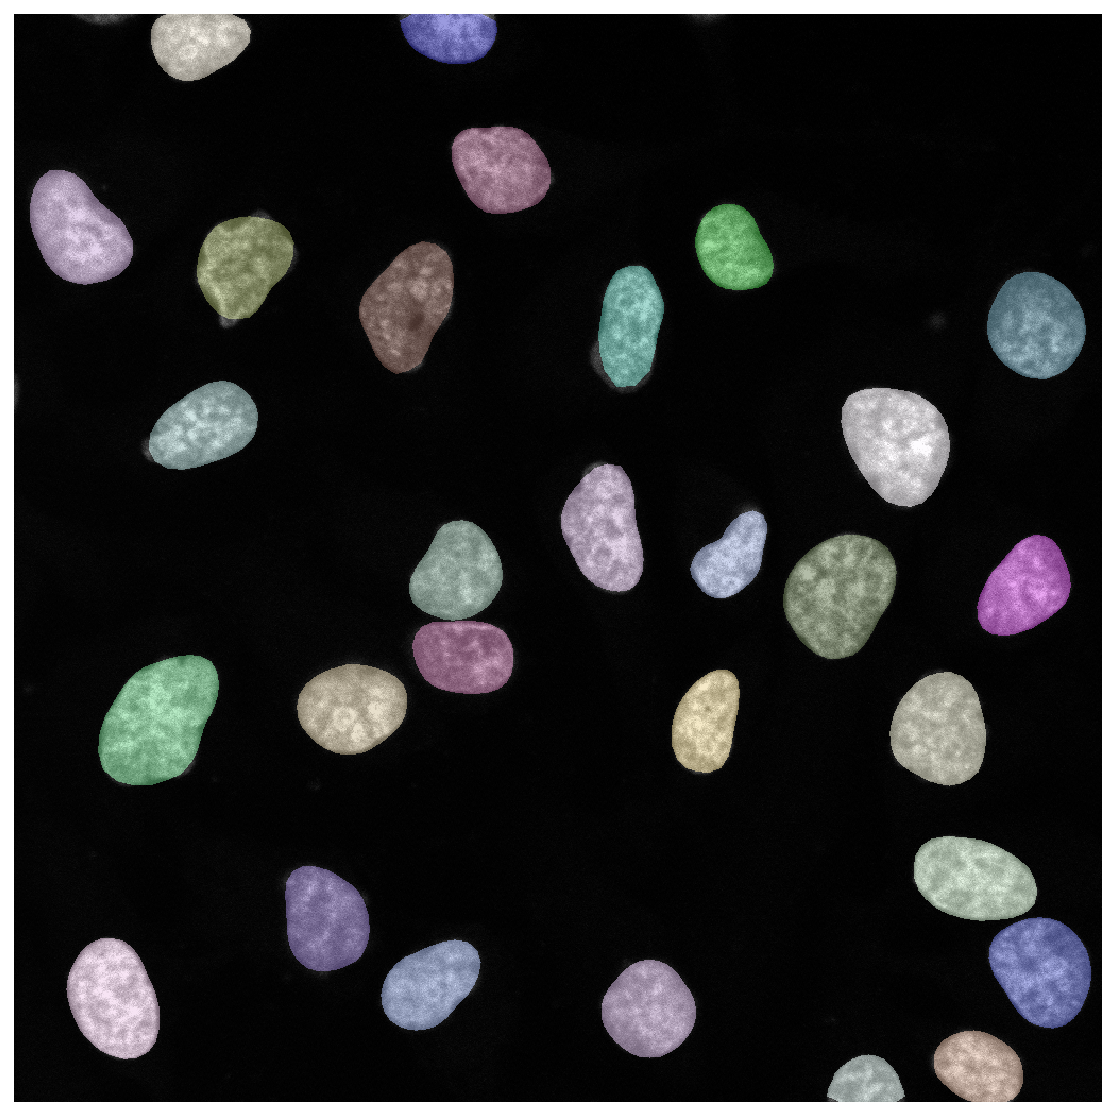

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(img, clim=(0,1), cmap='gray')
ax.imshow(labels, cmap=lbl_cmap, alpha=0.5)
ax.axis('off');

We are ready to measure each and every cell. But before we do that, consider the cells at the image border. They may be clipped of and give us a wrong impression about shape but also about their intensity values. We will measure **a lot** of cells in the end, so we can sacrifice a few and increase our reliability by just ignoring those cells. Luckily, 'scikit-image' has just the function for that.

In [11]:
from skimage.segmentation import clear_border

In [15]:
labels_cleared = clear_border(labels)

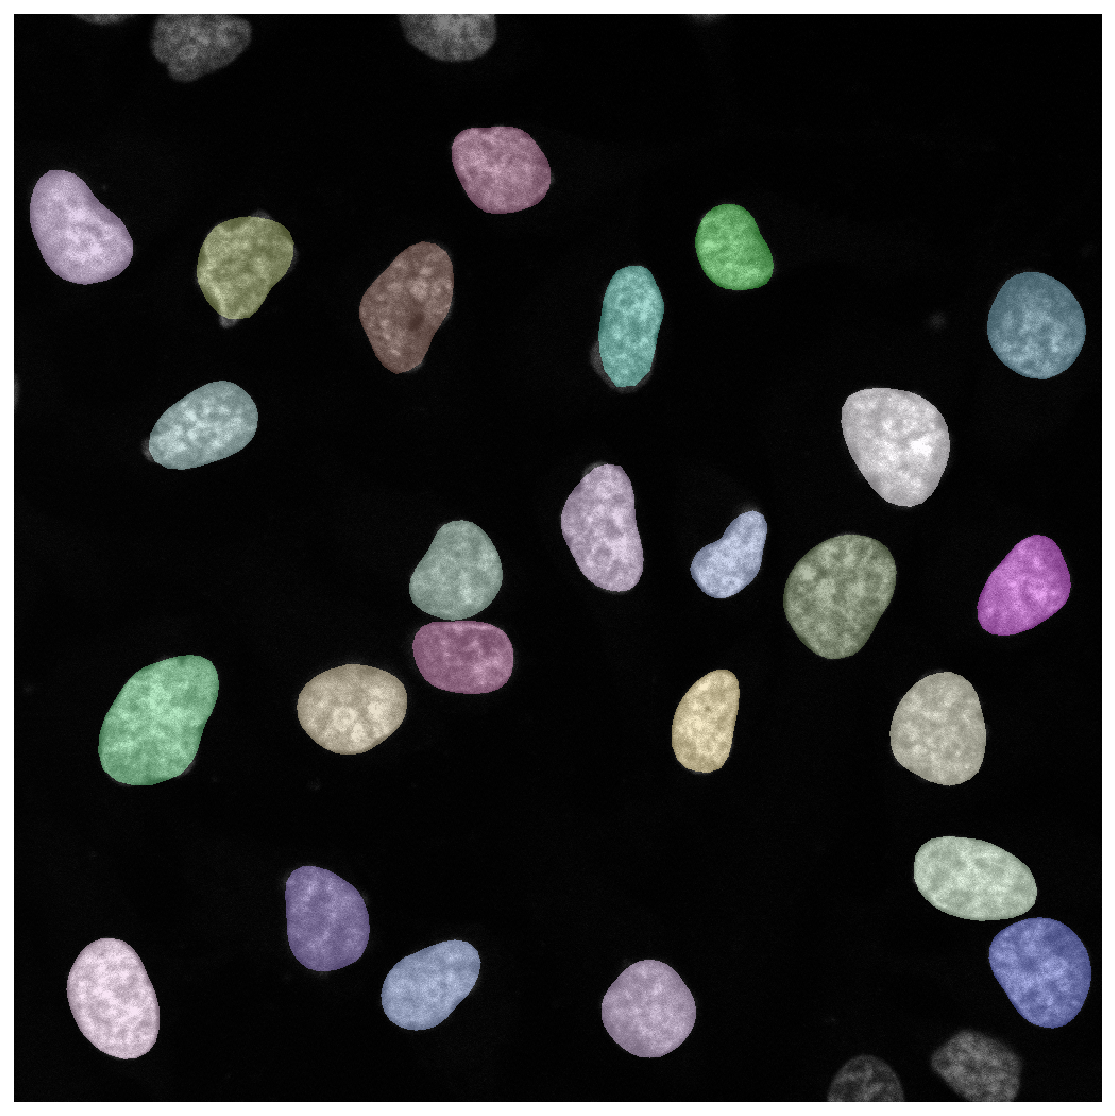

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(img, clim=(0,1), cmap='gray')
ax.imshow(labels_cleared, cmap=lbl_cmap, alpha=0.5)
ax.axis('off');

Now we are ready to measure. The function `regionprops` is made for that.

In [17]:
from skimage.measure import regionprops

In [20]:
props = regionprops(labels_cleared)

What's in the box? have a look at the result of calling regionprops.

In [21]:
props

So this is a list of regionprops objects. Have a look [what regionprops returns](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops). To output specic parameters we have to iterate through the list and call the cell feature with a specific method.

In [35]:
for item in props:
    print("Center of cell #{} is {:.2f} / {:.2f}.".format(item.label, item.centroid[1], item.centroid[0]))

Center of cell #1 is 675.05 / 510.99.
Center of cell #2 is 651.41 / 665.95.
Center of cell #4 is 579.45 / 292.43.
Center of cell #7 is 178.85 / 388.19.
Center of cell #8 is 422.96 / 604.06.
Center of cell #10 is 391.16 / 912.96.
Center of cell #11 is 135.61 / 664.72.
Center of cell #12 is 555.37 / 484.44.
Center of cell #13 is 902.84 / 814.04.
Center of cell #14 is 676.52 / 220.91.
Center of cell #15 is 292.30 / 851.89.
Center of cell #16 is 950.95 / 539.70.
Center of cell #17 is 317.69 / 652.89.
Center of cell #18 is 457.81 / 145.16.
Center of cell #19 is 215.27 / 235.13.
Center of cell #20 is 416.85 / 525.75.
Center of cell #21 is 830.30 / 403.48.
Center of cell #22 is 871.19 / 673.37.
Center of cell #23 is 597.11 / 936.65.
Center of cell #24 is 370.44 / 274.21.
Center of cell #25 is 93.65 / 926.97.
Center of cell #26 is 967.23 / 899.67.
Center of cell #27 is 776.76 / 545.61.
Center of cell #28 is 961.72 / 293.17.
Center of cell #29 is 59.45 / 203.42.


Note a few things:
  * Regionprops returns a list of all objects with their properties.
  * The Regionprops properties are accessed as attributes like so `regionprops_item.attribute`.
  * Depending on the attribute, this can be just a number (e.g. the label value of the label image), few values (e.g. a tuple for the X/Y coordinates of the object centroid) or many values (e.g. the coordinate list of the region)

We can also use the properties of 'regionprops' for plotting.

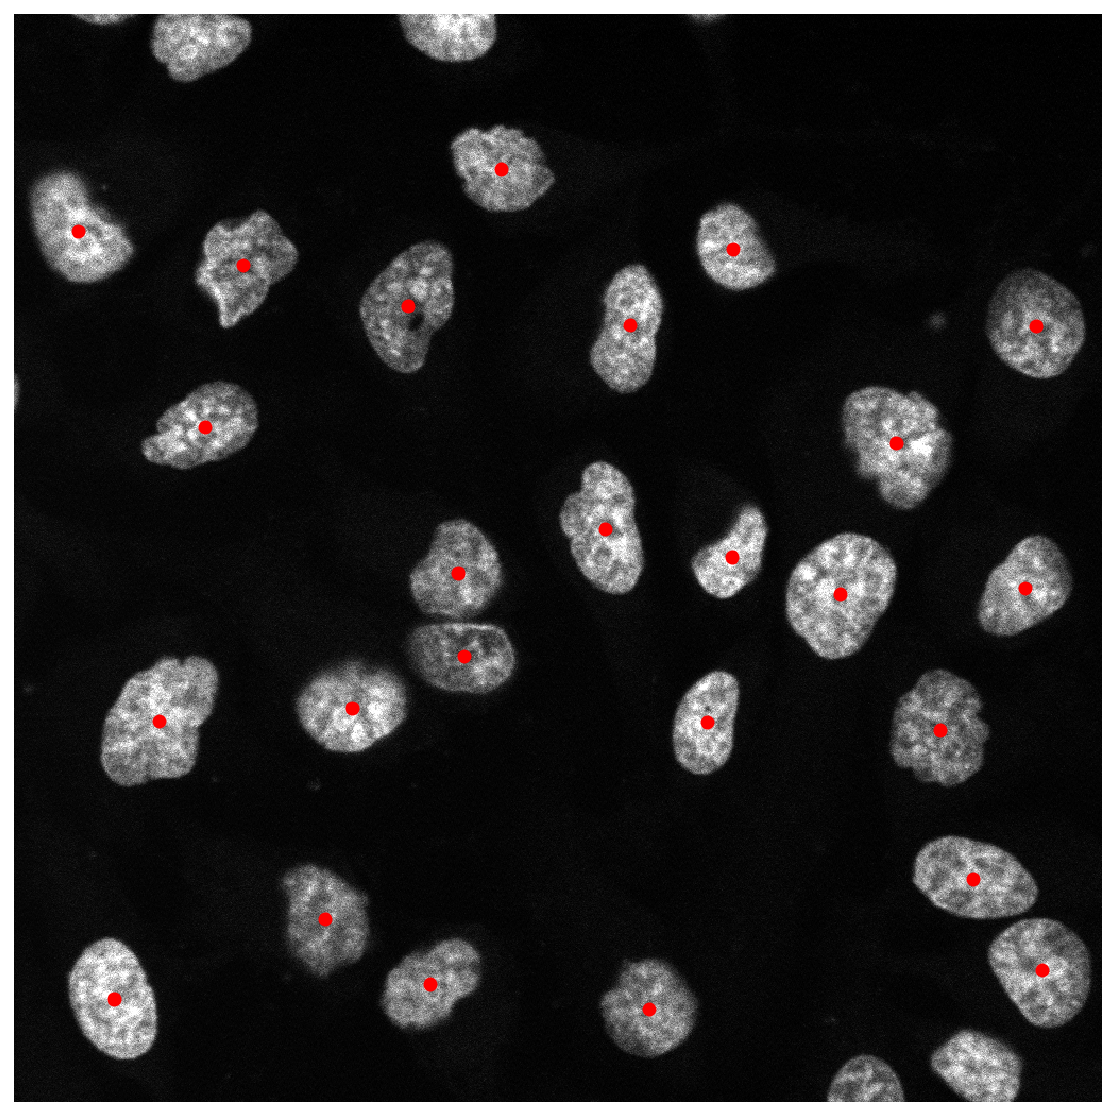

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(img, clim=(0,1), cmap='gray')
for item in props:
    ax.plot(item.centroid[1], item.centroid[0], 'ro') # plot as red circle
ax.axis('off');

So far we just used the label image. What if we want to analyze intensity values? We can convenently give regionprops an intensity image in addition to the label image.

In [67]:
props = regionprops(labels_cleared, intensity_image=X[0]) # our raw intensity image

Since scikit-image 0.18, we can pass multiple channels to regionprops. Here we use `numpy.stack` to combine both images. Note: For this approach to work, make sure that the shape of the array is correct! Regionprops expects that the channel is the last dimension.

In [95]:
np.stack([img,X[0]],2).shape

(1024, 1024, 2)

In [97]:
props = regionprops(labels_cleared, intensity_image=np.stack([img,X[0]],2)) 

Now we can get mean intensity values of both the normalized and raw images after running regionprops.

In [98]:
for item in props:
    print("Mean of cell #{} is normalized {:.2f} and raw {:.2f}".format(item.label, item.mean_intensity[0], item.mean_intensity[1]))

Mean of cell #1 is normalized 0.64 and raw 2883.88
Mean of cell #2 is normalized 0.60 and raw 2746.26
Mean of cell #4 is normalized 0.57 and raw 2605.51
Mean of cell #7 is normalized 0.49 and raw 2300.47
Mean of cell #8 is normalized 0.37 and raw 1852.30
Mean of cell #10 is normalized 0.45 and raw 2170.49
Mean of cell #11 is normalized 0.55 and raw 2543.67
Mean of cell #12 is normalized 0.57 and raw 2629.41
Mean of cell #13 is normalized 0.49 and raw 2306.11
Mean of cell #14 is normalized 0.55 and raw 2547.46
Mean of cell #15 is normalized 0.38 and raw 1890.92
Mean of cell #16 is normalized 0.50 and raw 2349.22
Mean of cell #17 is normalized 0.56 and raw 2585.03
Mean of cell #18 is normalized 0.48 and raw 2249.51
Mean of cell #19 is normalized 0.44 and raw 2117.42
Mean of cell #20 is normalized 0.44 and raw 2097.94
Mean of cell #21 is normalized 0.51 and raw 2394.31
Mean of cell #22 is normalized 0.39 and raw 1927.13
Mean of cell #23 is normalized 0.41 and raw 2007.58
Mean of cell #24 

This is nice but ideally we want to analyze the data and not just print it on the screen. A python library used frequently for data analysis is pandas. Pandas gives us functionality we know from 'R' data frames.

In [99]:
import pandas as pd

Pandas can convert lists to data frames if each row is again represented as a list (a so called 'list of lists'). Let's make one using **list comprehension**. Note that here we use the index of the channel of which we want to know the intensity parameters. If we just passed a single channel to regionprops, we would not need any index at all.

In [100]:
output_data = [ [item.label, item.mean_intensity[1], item.min_intensity[1], item.max_intensity[1]] for item in props ]

In [101]:
output_dataframe = pd.DataFrame(output_data, columns=['Label', 'Mean Raw', 'Min Raw', 'Max Raw'])

In [102]:
output_dataframe

Label     Mean Raw  Min Raw  Max Raw
0       1  2883.875977    483.0   5378.0
1       2  2746.255615    597.0   6077.0
2       4  2605.513428    573.0   5374.0
3       7  2300.469482    461.0   5273.0
4       8  1852.295166    627.0   4212.0
5      10  2170.491455    517.0   4350.0
6      11  2543.666504    444.0   5503.0
7      12  2629.411133    477.0   5311.0
8      13  2306.114746    497.0   4684.0
9      14  2547.462646    537.0   5293.0
10     15  1890.915405    574.0   4407.0
11     16  2349.224121    420.0   5416.0
12     17  2585.033691    564.0   5786.0
13     18  2249.511230    446.0   4699.0
14     19  2117.423828    458.0   5217.0
15     20  2097.943359    551.0   5217.0
16     21  2394.307617    530.0   6235.0
17     22  1927.131714    512.0   3959.0
18     23  2007.580078    537.0   4256.0
19     24  1849.641846    462.0   4061.0
20     25  2995.820068    539.0   5828.0
21     26  2278.818115    489.0   4981.0
22     27  2707.460693    551.0   6434.0
23     28  1924.848999    558.0   4541.0
24     29  2508.096436    545.0   5376.0

Pandas comes with some basic plotting functions that are based on 'matplotlib'. So we can explore our data with just one command. Because it is based on 'matplotlib', we can pass arguments like the figure size.

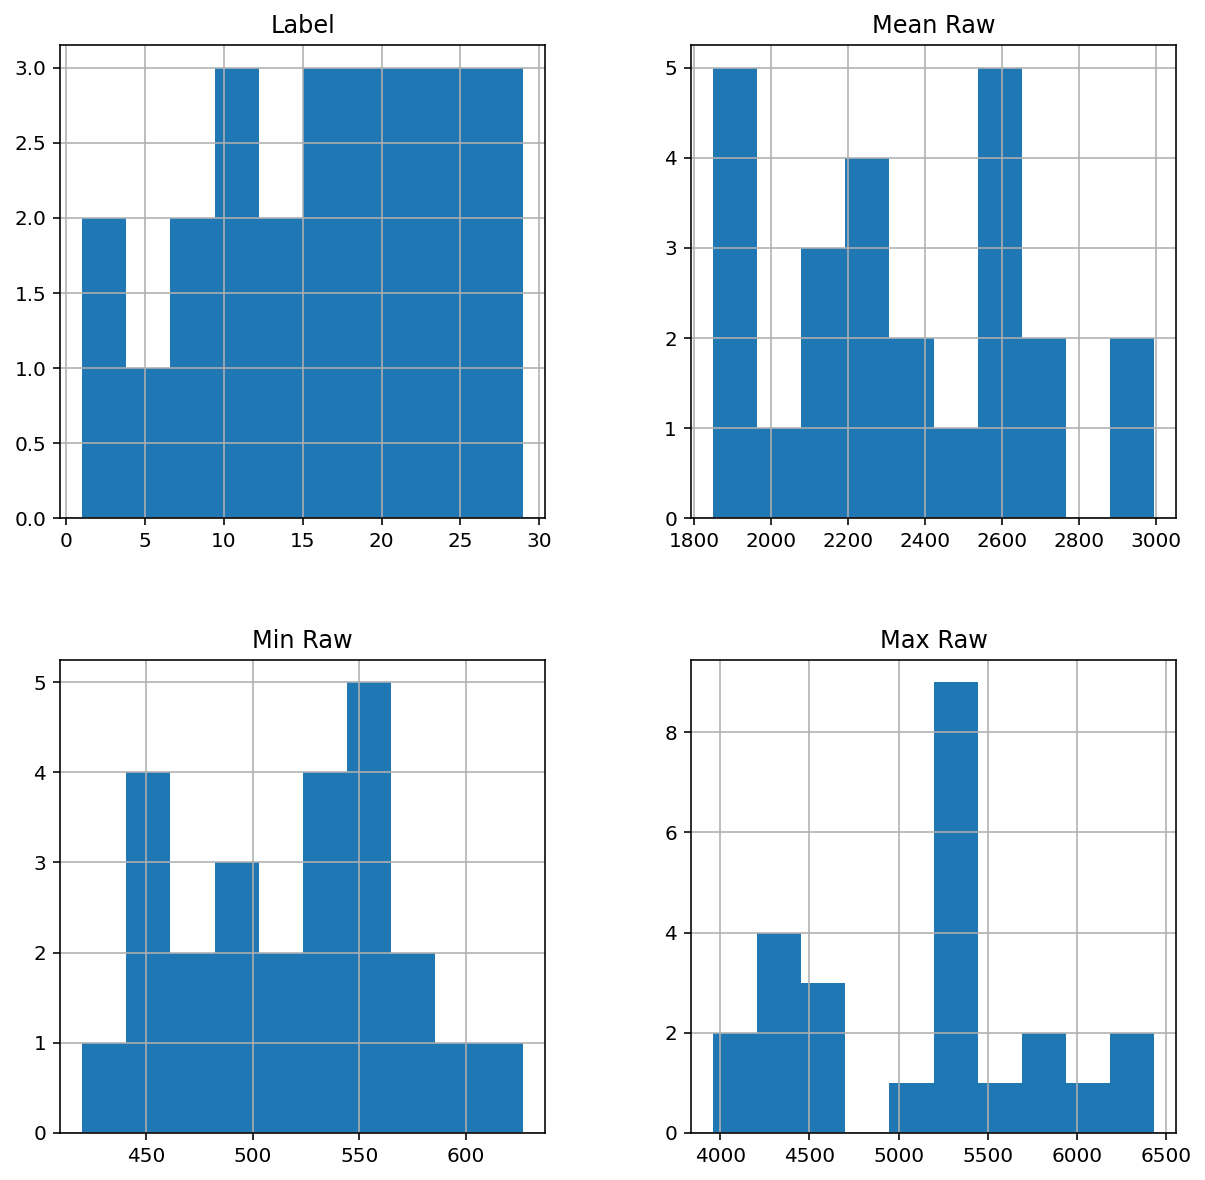

In [103]:
output_dataframe.hist(figsize=(10,10));

Of course we can also use boolean indexing with Pandas.

In [106]:
output_dataframe[output_dataframe['Mean Raw'] > 2500]

Label     Mean Raw  Min Raw  Max Raw
0       1  2883.875977    483.0   5378.0
1       2  2746.255615    597.0   6077.0
2       4  2605.513428    573.0   5374.0
6      11  2543.666504    444.0   5503.0
7      12  2629.411133    477.0   5311.0
9      14  2547.462646    537.0   5293.0
12     17  2585.033691    564.0   5786.0
20     25  2995.820068    539.0   5828.0
22     27  2707.460693    551.0   6434.0
24     29  2508.096436    545.0   5376.0

And we can easily save a pandas data frame to a csv file.

In [107]:
output_dataframe.to_csv('my_dataframe.csv')